In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1 General Port Parameters

In [2]:
year              = 2018   # current year within simulation
simulation_window = 20     # looking 20 years ahead
start_year        = 2018   # start year of simulation
timestep          = year - start_year
operational_hours = 8760   # operational hours per year

# 2 Scenario Generator

In [3]:
from terminal_optimization.forecast import maize, soybean, wheat, handysize, handymax, panamax
from terminal_optimization.plot_file import plot_trend

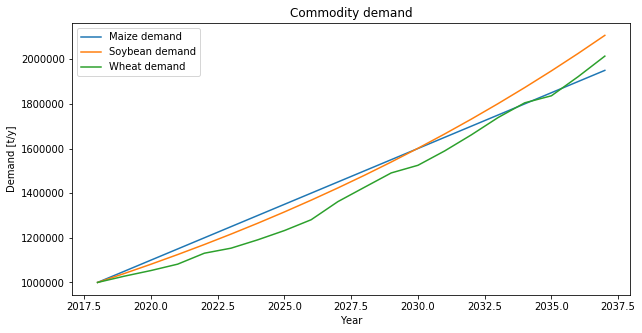

In [4]:
# Generating a single demand forecast

# Maize - Linear demand
demand_maize  = 1000000        # demand at t=0
growth_maize  = 50000       
rate_maize    = 1.01       # year on year growth rate of demand (% points) - input for constant method and random method
mu_maize      = 0          # avg bonus rate added to base rate (% points)  - input for random method
sigma_maize   = 0          # standard deviation of bonus rate (% points)   - input for random method

# Soybean - Exponential demand
demand_soybean = 1000000
rate_soybean   = 1.04
mu_soybean     = 0
sigma_soybean  = 0

# Wheat - Probabilistic demand
demand_wheat   = 1000000
rate_wheat     = 1.03
mu_wheat       = 0.01
sigma_wheat    = 0.015

maize.linear_forecast        (year, simulation_window, demand_maize, growth_maize)
soybean.exponential_forecast (year, simulation_window, demand_soybean, rate_soybean)
wheat.random_forecast        (year, simulation_window, demand_wheat, rate_wheat, mu_wheat, sigma_wheat)

plot_trend(maize, soybean, wheat, 10, 5)

# 3 Port Model
## 3.1 Import/export of data
*The following packages are imported:* 
- [infrastructure package]: Imports all infrastructure classes 
- [investment decision package]: Combines current commodity demand and infrastructure characteristics to decide whether to invest in terminal elements
<br>

*The following overacrching classes are exported:* 
- port parameters (e.g. simulation timestep, operational hours etc.)
- commodities (includes forecast characteristics)
- vessels 

In [5]:
import terminal_optimization.investment_decisions as invest
import terminal_optimization.infrastructure       as infra
import terminal_optimization.business_logic       as financial

## 3.2 Investment decisions

### 3.2.1 Berth investment decision
Starting with a single berth and asuming that vessels are distributed equally between all berths, the berth occupancy is calculated. If the occupancy is above the set 'allowable berth occupancy' an extra berth is added and the calculation is iterated

In [6]:
# at t=0 import berth and crane classes from infrastructure package and run initial berth configuration
if timestep == 0:
    berth_object = infra.berth_object
    cranes_object = infra.cranes_object
    berths = [berth_object]
    cranes = [cranes_object[0]], [cranes_object[1]], [cranes_object[2]], [cranes_object[3]]
    berths = invest.initial_berth_setup(berths, cranes, handysize, handymax, panamax, timestep)
    
# for each time step, check whether pending assets come online
berths = invest.berth_online_transition(berths, year)
    
# for each time step, decide whether to invest in berths
invest_decision = invest.berth_invest_decision(berths, cranes, handysize, handymax, panamax, timestep, operational_hours)
berth_invest_decision = invest_decision[0]
berths = invest_decision[1]

# if investments are needed, calculate how much berths should be added
if berth_invest_decision == 'Invest in berths':
    berths = invest.berth_expansion(berths, berth_object, cranes, handysize, handymax, panamax, year, timestep, operational_hours)
else:
    berths[0].delta = 0

print ('Number of berths added:  ', berths[0].delta)
print ('Pending number of berths:', berths[0].pending_quantity)
print ('Current number of berths:', berths[0].online_quantity)

Number of berths added:   1
Pending number of berths: 1
Current number of berths: 0


### 3.2.2 Quay investment decision
In this setup, the decision to expand the quay is based on whether berth expansions are plannen or not. The length of the quay is defined as the sum of the length of the berths 

In [7]:
# at t=0 import quay class from infrastructure package and run initial quay configuration
if timestep == 0:
    quay_object = infra.quay_object
    quays = [quay_object]
    quays = invest.initial_quay_setup(quays)

# for each time step, check whether pending assets come online
quays = invest.quay_online_transition(quays, year)
    
# for each time step, decide whether to invest in the quay
quay_invest_decision = invest.quay_invest_decision(berths, quays, year)

# if investments are needed, calculate how much quay length should be added
if quay_invest_decision == 'Invest in quay':
    quays = invest.quay_expansion(quays, quay_object, berths, year)
else:
    quays[0].delta = 0
    
print ('Meters of quay added: ', quays[0].delta)
print ('Current quay length:  ', quays[0].online_length)

Meters of quay added:  250
Current quay length:   0


### 3.2.3 Crane investment decision
In this setup, the number of cranes is solely goverened by the number of berths. The number of cranes per berth is equal to the number of cranes that can work simultaeously on the largest vessel that calls to port during the current timestep. E.g. two cranes per berth in years where handymax is the largest vessel and three cranes per berth in years where panamax is the largest vessel

In [8]:
# at t=0 import cranes class from infrastructure package and run initial crane configuration
if timestep == 0:
    cranes = invest.initial_crane_setup(cranes)
    
# for each time step, check whether pending assets come online
cranes = invest.crane_online_transition(cranes, year)
    
# for each time step, decide whether to invest in the cranes
crane_invest_decision = invest.crane_invest_decision(cranes, berths, year)

# if investments are needed, calculate how much cranes should be added
if crane_invest_decision == 'Invest in cranes':
    cranes = invest.crane_expansion(cranes, cranes_object, berths, year)
else:
    for i in range (4):
        cranes[i][0].delta = 0

print ('Number of berths added:', berths[0].delta)
print ('Gantry cranes added:   ', cranes[0][0].delta)
print ('Harbour cranes added:  ', cranes[1][0].delta)
print ('Mobile cranes added:   ', cranes[2][0].delta)
print ('Screw unloaders added: ', cranes[3][0].delta)

Number of berths added: 1
Gantry cranes added:    3
Harbour cranes added:   0
Mobile cranes added:    0
Screw unloaders added:  0


### 3.2.3 Storage investment decision
In this setup, the storage investment is triggered whenever the storage capacity equals 10% of yearly demand. Once triggered, the storage is expanded to accomodate 20% of yearly throughput

In [9]:
# at t=0 import storage class from infrastructure package and run initial storage configuration
if timestep == 0:
    silo_object = infra.silo_object
    warehouse_object = infra.warehouse_object
    storage = [[silo_object], [warehouse_object]]
    storage = invest.initial_storage_setup(storage)
    
# for each time step, check whether pending assets come online
storage = invest.storage_online_transition(storage, year)
    
# for each time step, decide whether to invest in storage
invest_decision = invest.storage_invest_decision(storage, maize, soybean, wheat, timestep)
storage_invest_decision = invest_decision[0]
storage = invest_decision[1]

# if investments are needed, calculate how much extra capacity should be added
if storage_invest_decision == 'Invest in storage':
    storage = invest.storage_expansion(storage, year)
else:
    storage[0][0].delta = 0
    storage[1][0].delta = 0

print ('Silo capacity added (t):       ', storage[0][0].delta)
print ('Current silo capacity (t):     ', storage[0][0].online_capacity)
print ('Warehouse capacity added (t):  ', storage[1][0].delta)
print ('Current warehouse capacity (t):', storage[1][0].online_capacity)

Silo capacity added (t):        3600000
Current silo capacity (t):      0
Warehouse capacity added (t):   0
Current warehouse capacity (t): 0


### 3.2.4 Loading station investment decision
In this setup, it is assumed that the loading station has a utilisation rate of 60%. The loading station investment is triggered whenever the yearly loading capacity equals 80% of yearly demand, taking the utilisation rate into account. Once triggered, the loading rate is expanded to accomodate 120% of yearly throughput in steps of 300 t/h

In [10]:
# at t=0 import loading station class from infrastructure package and run initial laoding station configuration
if timestep == 0:
    station_object = infra.station_object
    stations = [station_object]
    station_object = invest.initial_station_setup(stations)
    
# for each time step, check whether pending assets come online
stations = invest.station_online_transition(stations, year)
    
# for each time step, decide whether to invest in storage
stations_invest_decision = invest.station_invest_decision(stations, maize, soybean, wheat, timestep, operational_hours)

# if investments are needed, calculate how much extra capacity should be added
if stations_invest_decision == 'Invest in loading stations':
    stations = invest.station_expansion(stations, maize, soybean, wheat, year, timestep, operational_hours)
else:
    stations[0].delta = 0

print ('Loading station capacity added (t/h):  ', stations[0].delta)
print ('Current loading station capacity (t/h):', stations[0].online_capacity)

Loading station capacity added (t/h):   900
Current loading station capacity (t/h): 0


### 3.2.5 Conveyor investment decision
#### 3.2.5.1 Quay conveyor
In this setup, the quay-side conveyor investment dicision is triggered whenever the the crane investment is triggered. The conveyor capacity is always sufficient to cope with the cranes' peak unloading capacity. It is assumed that each additional conveyor built increases conveying capacity by 400 t/h.

In [11]:
# at t=0 import conveyor class from infrastructure package and run initial conveyor configuration
if timestep == 0:
    quay_conveyor_object = infra.quay_conveyor_object
    q_conveyors = [quay_conveyor_object]
    q_conveyors = invest.initial_conveyor_setup(q_conveyors)
    
# for each time step, check whether pending assets come online
q_conveyors = invest.conveyor_online_transition(q_conveyors, year)
    
# for each time step, decide whether to invest in quay conveyors
invest_decision = invest.quay_conveyor_invest_decision(q_conveyors, cranes)
quay_conveyor_invest_decision = invest_decision[0]
q_conveyors = invest_decision[1]

# if investments are needed, calculate how much extra capacity should be added
if quay_conveyor_invest_decision == 'Invest in quay conveyors':
    q_conveyors = invest.quay_conveyor_expansion(q_conveyors, cranes, year)
else:
    q_conveyors[0].delta = 0

print ('Quay conveyor length (m):             ', q_conveyors[0].length)
print ('Quay conveying capacity added (t/h):  ', q_conveyors[0].delta)
print ('Current quay conveying capacity (t/h):', q_conveyors[0].online_capacity)

Quay conveyor length (m):              500
Quay conveying capacity added (t/h):   9200
Current quay conveying capacity (t/h): 0


#### 3.2.5.1 Hinterland conveyor
In this setup, the hinterland conveyor investment dicision is triggered whenever the loading station investment is triggered. The conveyor capacity is always sufficient to cope with the hinterland loading stations' capacity. It is assumed that each additional conveyor built increases conveying capacity by 400 t/h.

In [12]:
# at t=0 import conveyor class from infrastructure package and run initial conveyor configuration
if timestep == 0:
    hinterland_conveyor_object = infra.hinterland_conveyor_object
    h_conveyors = [hinterland_conveyor_object]
    h_conveyors = invest.initial_conveyor_setup(h_conveyors)
    
# for each time step, check whether pending assets come online
h_conveyors = invest.conveyor_online_transition(h_conveyors, year)
    
# for each time step, decide whether to invest in quay conveyors
invest_decision = invest.hinterland_conveyor_invest_decision(h_conveyors, stations)
quay_conveyor_invest_decision = invest_decision[0]
h_conveyors = invest_decision[1]

# if investments are needed, calculate how much extra capacity should be added
if quay_conveyor_invest_decision == 'Invest in hinterland conveyors':
    h_conveyors = invest.hinterland_conveyor_expansion(h_conveyors, stations, year)
else:
    h_conveyors[0].delta = 0

print ('Hinterland conveyor length (m):             ', h_conveyors[0].length)
print ('Hinterland conveying capacity added (t/h):  ', h_conveyors[0].delta)
print ('Current hinterland conveying capacity (t/h):', h_conveyors[0].online_capacity)

Hinterland conveyor length (m):              500
Hinterland conveying capacity added (t/h):   1200
Current hinterland conveying capacity (t/h): 0


## 3.3 Overall Terminal Throughput

In [13]:
quay_throughput = invest.quay_throughput(berths, cranes)
terminal_throughput = quay_throughput
print ('Terminal throughput (t/y):  ',terminal_throughput)

Terminal throughput (t/y):   0


## 3.4 Business Logic

In [14]:
if timestep == 0:
    fin_calcs = financial.business_logic_objects(start_year, simulation_window)
assets = [quays, cranes, storage, stations, q_conveyors, h_conveyors]

### 3.4.1 Revenue 

In [15]:
# at t=0 import revenue class from infrastructure package
if timestep == 0:
    revenues = fin_calcs[0]
    
# for each time step, compute the incoming revenues
revenues[timestep].calc(maize, soybean, wheat, terminal_throughput, timestep)

print ('Maize revenue ($):  ', revenues[timestep].maize)
print ('Soybean revenue ($):', revenues[timestep].soybean)
print ('Wheat revenue ($):  ', revenues[timestep].wheat)
print ('Total revenue ($):  ', revenues[timestep].total)

Maize revenue ($):   0
Soybean revenue ($): 0
Wheat revenue ($):   0
Total revenue ($):   0


### 3.4.2 Capex

In [16]:
# at t=0 import capex class from infrastructure package
if timestep == 0:
    capex = fin_calcs[1]
    
# for each time step, compute the capex
capex[timestep].calc(assets)

print ('Quay capex($)           ', capex[timestep].quay)
print ('Crane capex($)          ', capex[timestep].cranes)
print ('Storage capex($)        ', capex[timestep].storage)
print ('Conveyor capex($)       ', capex[timestep].conveyors)
print ('Loading station capex($)', capex[timestep].loading_stations)
print ('Total capex ($):        ', capex[timestep].total)

Quay capex($)            18924000
Crane capex($)           67275000
Storage capex($)         220320000
Conveyor capex($)        31260000
Loading station capex($) 3700000
Total capex ($):         341479000


### 3.4.3 Labour costs

In [17]:
# at t=0 import labour cost class from infrastructure package
if timestep == 0:
    labour = fin_calcs[2]
    
# for each time step, compute the labour costs
labour[timestep].calc(assets)

print ('International staff costs($):', labour[timestep].international_salary * labour[timestep].international_staff)
print ('Local staff costs($):        ', labour[timestep].local_salary         * labour[timestep].local_staff)
print ('Operational staff costs($):  ', labour[timestep].operational_salary   * labour[timestep].operational_staff)
print ('Total costs($):              ', labour[timestep].total_costs)

International staff costs($): 420000
Local staff costs($):         188500
Operational staff costs($):   0.0
Total costs($):               608500


### 3.4.4 Maintenance costs

In [18]:
# at t=0 import maintenance cost class from infrastructure package
if timestep == 0:
    maintenance = fin_calcs[3]
    
# for each time step, compute the maintenance costs
maintenance[timestep].calc(assets)

print ('Quay maintenance costs($):    ', maintenance[timestep].quay)
print ('Crane maintenance costs($):   ', maintenance[timestep].cranes)
print ('Storage maintenance costs($): ', maintenance[timestep].storage)
print ('Conveyor maintenance costs($):', maintenance[timestep].conveyors)
print ('Total maintenance costs($):   ', maintenance[timestep].total_costs)

Quay maintenance costs($):     0
Crane maintenance costs($):    0
Storage maintenance costs($):  0
Conveyor maintenance costs($): 0
Total maintenance costs($):    0


### 3.4.5 Energy costs

In [19]:
energy = fin_calcs[4]

### 3.4.6 Demurrage costs

In [20]:
demurrage = fin_calcs[5]